In [1]:
import pandas as pd
df = pd.read_csv('temperature.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [2]:
df = df.iloc[:200000:6]
df = df.drop(columns=['Date Time'])

mean = df.mean()
std = df.std()
df = (df-mean)/std

df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.900080,-1.931243,-1.982008,-1.862774,1.073091,-1.307358,-1.473784,-0.798768,-1.476283,-1.478172,2.123687,-0.727723,-0.779684,-0.277693
6,0.897721,-1.886062,-1.936218,-1.779038,1.162756,-1.293054,-1.438047,-0.807030,-1.438763,-1.442890,2.074970,-1.281252,-1.260773,-0.114206
12,0.913050,-2.024996,-2.074707,-1.974423,1.085046,-1.334667,-1.519050,-0.802899,-1.521308,-1.522864,2.226299,-1.294276,-1.316614,-0.208614
18,0.941348,-2.023866,-2.075824,-1.973027,1.085046,-1.333367,-1.519050,-0.802899,-1.517556,-1.522864,2.232418,-1.352885,-1.424000,-0.542494
24,0.962572,-2.067919,-2.121614,-2.051181,1.007336,-1.346371,-1.550021,-0.794637,-1.551324,-1.553442,2.285372,-1.333349,-1.368159,0.316385


In [3]:
import numpy as np

pastDay=1
futureDay=10

X, y = [], []
for i in range(df.shape[0]-futureDay-pastDay):
    X.append(np.array(df.iloc[i:i+pastDay]))
    y.append(np.array(df.iloc[i+pastDay:i+pastDay+futureDay]["T (degC)"]))

X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(33323, 1, 14) (33323, 10)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29990, 1, 14) (3333, 1, 14) (29990, 10) (3333, 10)


In [5]:
y_train = y_train[:,:,np.newaxis]
y_test = y_test[:,:,np.newaxis]
print(y_train.shape, y_test.shape)

(29990, 10, 1) (3333, 10, 1)


In [6]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth =True

#set_session(tf.compat.v1.Session(config=config)) 
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Using TensorFlow backend.


In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(RepeatVector(10))
model.add(TimeDistributed(Dense(1)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                1000      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 10)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 1)             11        
Total params: 1,011
Trainable params: 1,011
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss="mse", optimizer="adam")
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.1, callbacks=[callback])

Train on 26991 samples, validate on 2999 samples
Epoch 1/1000
26991/26991 [==============================] - 1s 54us/step - loss: 0.3270 - val_loss: 0.2045
Epoch 2/1000
26991/26991 [==============================] - 1s 34us/step - loss: 0.1878 - val_loss: 0.1797
Epoch 3/1000
26991/26991 [==============================] - 1s 34us/step - loss: 0.1726 - val_loss: 0.1718
Epoch 4/1000
26991/26991 [==============================] - 1s 35us/step - loss: 0.1670 - val_loss: 0.1677
Epoch 5/1000
26991/26991 [==============================] - 1s 34us/step - loss: 0.1646 - val_loss: 0.1659
Epoch 6/1000
26991/26991 [==============================] - 1s 35us/step - loss: 0.1633 - val_loss: 0.1647
Epoch 7/1000
26991/26991 [==============================] - 1s 37us/step - loss: 0.1622 - val_loss: 0.1639
Epoch 8/1000
26991/26991 [==============================] - 1s 32us/step - loss: 0.1615 - val_loss: 0.1634
Epoch 9/1000
26991/26991 [==============================] - 1s 33us/step - loss: 0.1609 - val_l

26991/26991 [==============================] - 1s 32us/step - loss: 0.1546 - val_loss: 0.1566
Epoch 77/1000
26991/26991 [==============================] - 1s 31us/step - loss: 0.1546 - val_loss: 0.1563
Epoch 78/1000
26991/26991 [==============================] - 1s 31us/step - loss: 0.1545 - val_loss: 0.1567
Epoch 79/1000
26991/26991 [==============================] - 1s 32us/step - loss: 0.1545 - val_loss: 0.1568
Epoch 80/1000
26991/26991 [==============================] - 1s 31us/step - loss: 0.1544 - val_loss: 0.1564
Epoch 81/1000
26991/26991 [==============================] - 1s 33us/step - loss: 0.1544 - val_loss: 0.1562
Epoch 82/1000
26991/26991 [==============================] - 1s 32us/step - loss: 0.1545 - val_loss: 0.1564
Epoch 83/1000
26991/26991 [==============================] - 1s 32us/step - loss: 0.1545 - val_loss: 0.1561
Epoch 84/1000
26991/26991 [==============================] - 1s 33us/step - loss: 0.1544 - val_loss: 0.1564
Epoch 85/1000
26991/26991 [===============

In [9]:
results = model.evaluate(X_test, y_test)
print(results)

3333/3333 [==============================] - 0s 60us/step
0.15042950927835666


dict_keys(['val_loss', 'loss'])


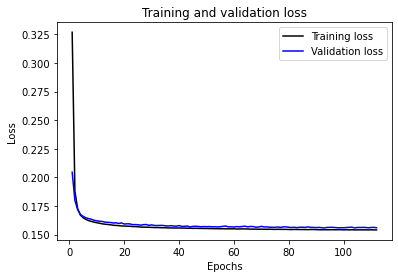

In [10]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b', color='k', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', color='b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()